  0%|          | 0/1000 [00:00<?, ?it/s]C:\Users\stars\AppData\Local\Temp\ipykernel_22580\1121470469.py:44: RuntimeWarning: invalid value encountered in scalar power
  dHRPRdt = np.where(AHL >= 0, (((k1 * AHL)**n3) / (AHL**n1 + k1**n1)), 0) + kHRPL * (
  0%|          | 0/1000 [00:00<?, ?it/s]


time for ODE45,  0.16423829999985173


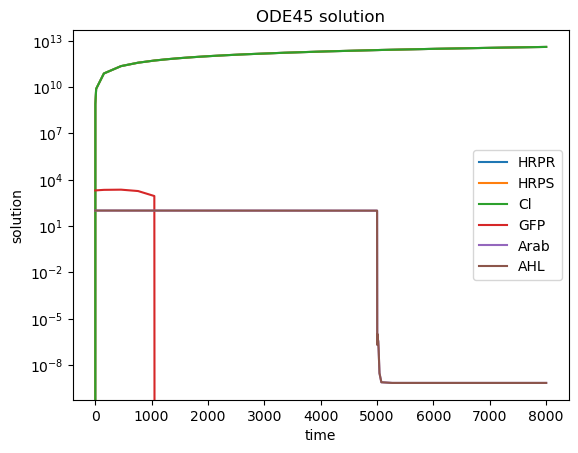

In [5]:
import numpy as np
import scipy.integrate
import matplotlib.pyplot as plt
from timeit import default_timer as timer
from tqdm import tqdm

alpha1 = 0.03 #leakage value of LuxR promoter
k1 = 1970 # Maximum rate of expression of LuxR promoter when activated and bound to weak ribosomal bounding site
n1 = 1.742 # Hill coefficient of LuxR promoter
K1 = (3.37 * 10**-6) # Dissociation constant of LuxR promoter
kHRPL = 750 #rate of HRPL promoter 
K2 = 206 # dissociation constant of HRPR
n2 = 2.4 # Hill coefficient of HRPR
K3 = 3135 # dissociation constant of HSPS
n3 = 1.8 # Hill coefficient of HSPS
alpha4 = 0.0013 # leakage value of Arabinose promoter
k4 = (1.29 * 10**4) # Maximum rate of expression of Arabinose promoter when activated and bound to weak ribosomal binding site
n4 = 1.323 # Hill coefficient of arabinose promoter
K4 = 0.513 # Dissociation constsant of Arabinose promoter
Cl = 0 # CI protein concentration 
k5 = 7.5 * 10**-4 # rate of production of GFP
d = 0.000001 # degradatin rate
HRPR0 = 0 # Initial concentration of HRPR0
HRPS0 = 0 # Initial concentration of HRPS0
GFP0 = 2000 # Initial concentration of GFP0
Cl0 = 0 # Initial concentration of CI
Arab0 = 100 #Initial concentration of Arabinose
AHL0 = 100 # Initial concentration of AHL
k6 = 10 # Rate of change of AHL
k7 = 10 # Rate of change of Arabinose
kI = 0.00000000001 # Rate of inhibition by CI
decay_factor = 0.1  # Rate of decay of AHL and Arabinose

def dydt(t, y, alpha1, k1, AHL, n1, K1, kHRPL, K2, n2, K3, n3, alpha4, k4, n4, K4, Arab0, AHL0, Cl, k5, d, HRPR0, HRPS0):
    HRPR, HRPS, GFP, Cl, Arab, AHL = y
    
    if t >= 5000: # Used to cause a loss of AHL and Arabinose at 5000 seconds
        dAHLdt = -k7 * np.exp(-decay_factor * (t - 5000)) * AHL
        dArabdt = -k7 * np.exp(-decay_factor * (t - 5000)) * Arab
    else:
        dAHLdt = 0
        dArabdt = 0
 # ODE equations for all reactions. np.where is used in any case where there may be a 0 and therefore an invalid value   
    dHRPRdt = np.where(AHL >= 0, (((k1 * AHL)**n3) / (AHL**n1 + k1**n1)), 0) + kHRPL * ( 
    ((K2 * np.where(HRPR >= 0, (HRPR**n2), 0)) / (np.where(HRPR >= 0, HRPR**n2, 0) + K2**n2)) *
    ((K3 * np.where(HRPS >= 0, HRPS**n3, 0)) / (np.where(HRPS >= 0, HRPS**n3, 0) + K3**n3))) - d * HRPR
    dHRPSdt = (np.power(np.abs(k4 * Arab), n4) / (np.abs(Arab)**n4 + np.abs(k4)**n4)) + kHRPL * (
        ((K2 * (HRPR**n2)) / (HRPR**n2 + K2**n2)) * ((K3 * (HRPS**n3)) / (HRPS**n3 + K3**n3))) - d * HRPS
    term = (K2 * (HRPR**n2) / (HRPR**n2 + K2**n2)) * ((K3 * (HRPS**n3) / (HRPS**n3 + K3**n3)))
    dCldt = kHRPL * term - d * Cl
    dGFPdt = k5 * GFP- kI*Cl - d * GFP
    
    return dHRPRdt, dHRPSdt, dGFPdt, dCldt, dArabdt, dAHLdt


y0 = (HRPR0, HRPS0, GFP0, Cl0, Arab0, AHL0)

dydt_withks = lambda t, y: dydt(t, y, alpha1, k1, y[5], n1, K1, kHRPL, K2, n2, K3, n3, alpha4, k4, n4, K4, y[4], y[5], y[3], k5, d, HRPR0, HRPS0)
# Begin timer and run simulation
start = timer()
with tqdm(total=1000) as pbar:
    def callback(t, y):
        pbar.update(1)
        return 
    solution = scipy.integrate.solve_ivp(dydt_withks, t_span=(0, 8000), y0=y0,
                                         method='RK45', rtol=1e-6, callback=callback) #ODE solver

end = timer()
time_for_num_int_by_ode45 = end - start
print("time for ODE45, ", time_for_num_int_by_ode45)

t_ode45 = solution.t
HRPR_ODE45, HRPS_ODE45, GFP_ODE45, Cl_ODE45, Arab_ODE45, AHL_ODE45 = solution.y
# Plot the resulting figure
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(t_ode45, HRPR_ODE45, label='HRPR')
ax.plot(t_ode45, HRPS_ODE45, label='HRPS')
ax.plot(t_ode45, Cl_ODE45, label='Cl')
ax.plot(t_ode45, GFP_ODE45, label='GFP')
ax.plot(t_ode45, Arab_ODE45, label='Arab')
ax.plot(t_ode45, AHL_ODE45, label='AHL')
ax.set_title('ODE45 solution')
ax.set_xlabel('time')
ax.set_yscale('log')
ax.set_ylabel('solution')
ax.legend()
plt.show()
